In [1]:
from tnia.plotting.projections import show_xy_zy_max, show_xy_zy_slice_center
from tnia.simulation.phantoms import random_sphere_phantom
from tnia.deconvolution.forward import forward
from pathlib import Path
from tnia.deeplearning.dl_helper import make_patch_directory, stardist_2d_slicewise
from tnia.deeplearning.augmentation import random_shift_slices_in_stack
from skimage.io import imsave
from tnia.morphology.connect import connect_2d_in_3d

In [9]:

tnia_images_path = Path("D:/images/tnia-python-images")
parent_path = tnia_images_path / "imagesc/2024_01_30_connect2d_in3d"
patches_path = parent_path / "patches"

images_paths, truth_paths=make_patch_directory(1,1,patches_path)

images_path = Path(images_paths[0])
truth_path = Path(truth_paths[0])

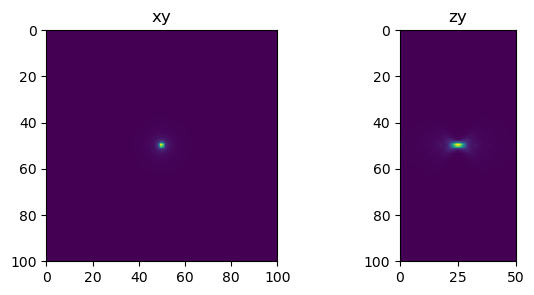

In [3]:
from tnia.deconvolution.psfs import gibson_lanni_3D

psf = gibson_lanni_3D(1.4, 1.5, 1.3, .1, .1, 100, 50, 0, .5, False, True)

fig = show_xy_zy_max(psf, figsize=(7,3))

In [5]:
from stardist.models import StarDist2D

# pretrained fluo
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


100%|██████████| 99/99 [00:01<00:00, 96.09it/s] 
268857832.py (8): D:\images\tnia-python-images\imagesc\2024_01_30_connect2d_in3d\patches\ground truth0\image_0.tif is a low contrast image
100%|██████████| 99/99 [00:01<00:00, 88.53it/s]
268857832.py (8): D:\images\tnia-python-images\imagesc\2024_01_30_connect2d_in3d\patches\ground truth0\image_1.tif is a low contrast image
100%|██████████| 99/99 [00:01<00:00, 83.97it/s]
268857832.py (8): D:\images\tnia-python-images\imagesc\2024_01_30_connect2d_in3d\patches\ground truth0\image_2.tif is a low contrast image
100%|██████████| 99/99 [00:01<00:00, 93.29it/s] 
268857832.py (8): D:\images\tnia-python-images\imagesc\2024_01_30_connect2d_in3d\patches\ground truth0\image_3.tif is a low contrast image
100%|██████████| 99/99 [00:01<00:00, 98.57it/s] 
268857832.py (8): D:\images\tnia-python-images\imagesc\2024_01_30_connect2d_in3d\patches\ground truth0\image_4.tif is a low contrast image


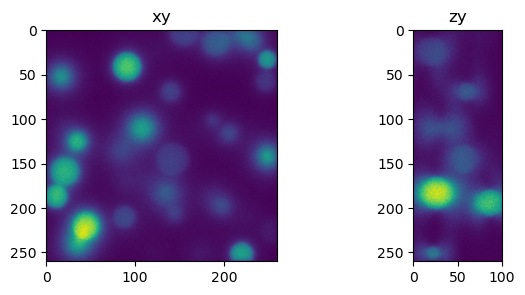

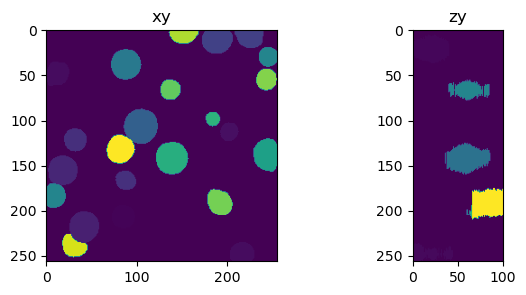

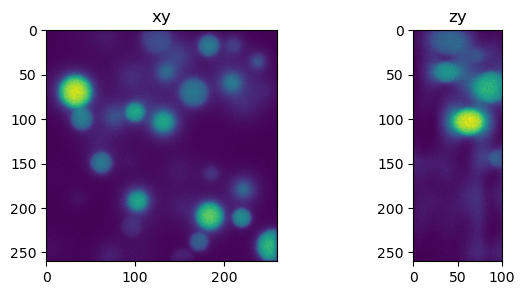

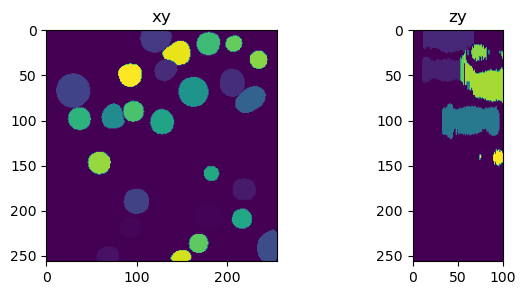

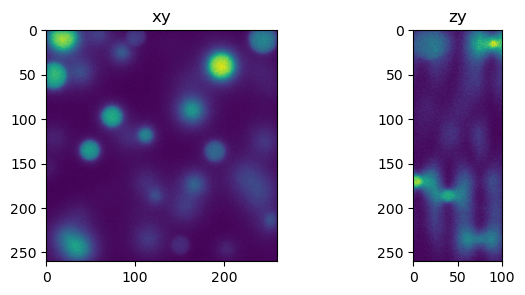

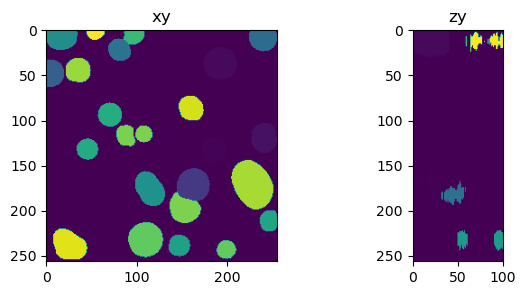

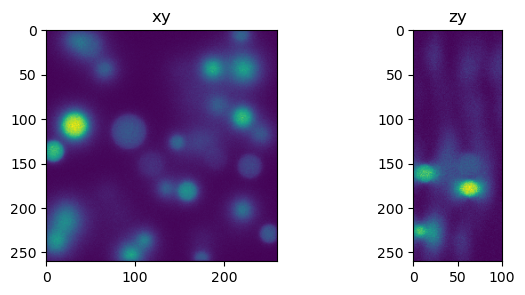

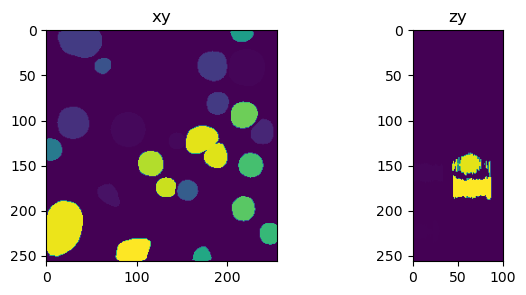

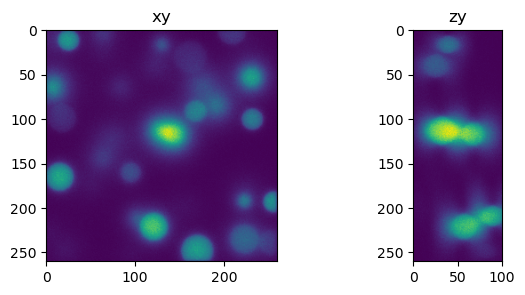

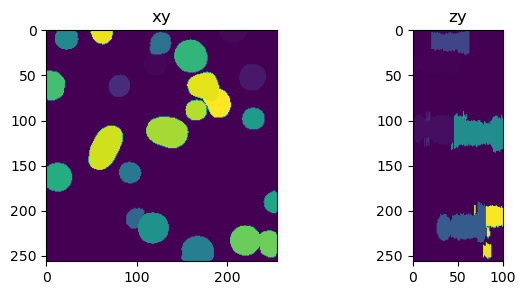

In [10]:
for i in range(5):
    img = random_sphere_phantom(260,260,100, 100, 10, 20, None)
    img_forward = forward(.01*img, psf, 10, True, True)
    img_shifted = random_shift_slices_in_stack(img_forward, 2)
    labels = stardist_2d_slicewise(img_shifted, model, use_tqdm=True)
    labels_connected = connect_2d_in_3d(labels, 5, use_tqdm=True)
    imsave(images_path / f"image_{i}.tif", img_shifted)
    imsave(truth_path / f"image_{i}.tif", labels_connected)
    fig = show_xy_zy_slice_center(img_forward, figsize=(7,3))
    fig = show_xy_zy_slice_center(labels_connected, figsize=(7,3))

In [107]:
import napari
viewer = napari.Viewer()
viewer.add_image(img_shifted)
viewer.add_labels(labels_connected)

<Labels layer 'labels_connected' at 0x289d1e996a0>

In [93]:

test_connected = connect_2d_in_3d(test, 5, True)

100%|██████████| 99/99 [00:00<00:00, 104.60it/s]


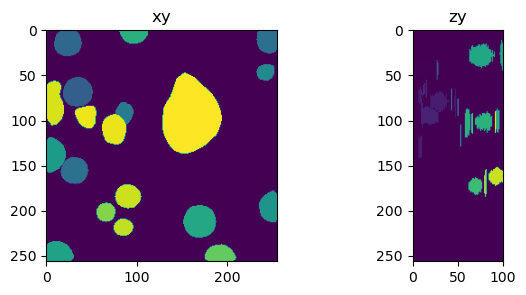

In [94]:
fig = show_xy_zy_slice_center(test_connected, figsize=(7,3))

In [73]:
import napari
viewer = napari.Viewer()
viewer.add_image(img_forward)
viewer.add_labels(test)
viewer.add_labels(test_connected)

<Labels layer 'test_connected' at 0x289c14392e0>

In [65]:
test=img_forward[38,:,:]

test.min(), test.max()

(3.0, 937.0)

array([ 0.06744197, -0.51859827,  0.15135716, -1.59856157])